In [42]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import warnings


warnings.filterwarnings('ignore')
datas =pd.read_csv("footballscores.csv")


## Question 1 : Identifying if there is a comeback tendency after halftime


In [43]:
cleaned = datas.dropna(axis = 0)
data = cleaned

In [44]:
def define_favorite(row):
    if row['PSH'] < row['PSA']:
        return row["HomeTeam"]
    elif row['PSA'] < row['PSH'] :
        return row['AwayTeam']
        
        #This method will outline which of the teams is the favorite
        
def define_halftime_up(row):
    if row['Favorite'] == row['HomeTeam'] and row['HTHG'] > row['HTAG']:
        return 'Favored'
    if row['Favorite'] == row['AwayTeam'] and row['HTHG'] < row['HTAG']:
        return 'Favored'
    if row['Favorite'] == row['AwayTeam'] and row['HTHG'] > row['HTAG']:
        return 'Unfavored'
    if row['Favorite'] == row['HomeTeam'] and row['HTHG'] < row['HTAG']:
        return 'Unfavored'
    if row['HTHG'] > 0:
        return 'Unfavored'
    return 'Tied'

#This method will outline if the favored or unfavored team is up at halftime, relative to pre-match odds
#This method defines the situation where teams are tied, and having more than one goal each (1-1, 2-2, etc)
# to be scenarios where the unfavored team is outperforming at halftime, and counts them as being "up", relative to pre match odds
#IF the game is 0-0 then it is classifed as a tie.

def define_comeback(row):
    if row['FTAG']>row['FTHG']:
        winner = row['AwayTeam']
    elif row['FTHG']>row['FTAG']:
        winner = row['HomeTeam']
    else:
        winner = "Draw"
    if row['Half_up'] == "Unfavored":
        if winner == row['Favorite']:
            return True
        else:
            return False
    if row['Half_up'] == "Favored":
        if winner != row['Favorite'] or winner == "Draw":
            return True
        else:
            return False
    if row['Half_up'] == "Tied":
        if winner != row['Favorite']:
            return True
        else:
            return False
# This method will define comebacks by determining the winner of the match.
#Then, if the winner was not up at halftime, it counts as a comeback. Also, if the game was tied at half and the unfavored team won, it counts as a comeback
#This tries to account for many circumstances, as there is more nuance to a comeback when we consider the odds


def define_true_comeback(row):
    if row['Half_up'] == "Favored":
            return row['Comeback']
    #So, Unfavored team up at half time
    elif row["Favorite"] == row['HomeTeam']:
        if row['Comeback']:
            if row['HTHG']+1<row['HTAG']:
                return True
            if row['PSH']+1>row['PSA']:
                return True
            else:
                return False
        else:
            return False
    elif row["Favorite"] == row['AwayTeam']:
        if row['Comeback']:
            if row['HTAG']+1<row['HTHG']:
                return True
            if row['PSA']+1>row['PSH']:
                return True
            else:
                return False
        else:
            return False
    return False

#This method will place further restrictions on our count of a comeback, only counting those comebacks where:
# - The unfavored team secured a comeback from being down at the half
# - The favored team (when their odds were similar to the unfavored team) come back from a deficit/underperformanced tie
# - The favored team (when their odds were generally much higher than the unfavored team) comes back from a deficit of more than one goal at the half





In [45]:
data['Favorite'] = data.apply(define_favorite, axis=1)
data['Half_up'] = data.apply(define_halftime_up, axis=1)
data['Comeback'] = data.apply(define_comeback, axis=1)
data['True_comeback'] = data.apply(define_true_comeback, axis=1)

In [46]:
games = data['Comeback']
comebacks = [i for i in games if i]
comeback_test = data['True_comeback']
true_comebacks = [i for i in comeback_test if i]

print(f"Percent comeback = {(len(comebacks)/len(games))*100}")
print(f"Percent true comeback = {(len(true_comebacks)/len(comebacks))*100}")
print(f"Overall percent true comeback = {(len(true_comebacks)/len(games))*100}")

#We see that a significant amount of comebacks are true comebacks, and they make up an non-negligible amount of total games




Percent comeback = 33.38887308489454
Percent true comeback = 46.969328140214216
Overall percent true comeback = 15.682529361563782


In [47]:
data['HTG'] = data['HTHG'] + data['HTAG']
data['FTG'] = data['FTHG'] + data['FTAG']
data['SHG'] = data['FTG'] - data['HTG']

In [48]:
#Now to plot this with a regression


def define_winning_goals(row):
    if row['Half_up'] == "Favored":
        if row['Favorite'] == row['HomeTeam']:
            return row['HTHG']
        else:
            return row['HTAG']
    else:
        if row['Favorite'] == row['HomeTeam']:
            return row['HTAG']
        else:
            return row['HTHG']
        
   #This method returns the amount of goals that the winning team at halftime has
def define_losing_goals(row):
    return row['HTG']-row['HTWG']
    
    #This method returns the amount of goals that the losing team at halftime has

def define_winning_SH_goals(row):
    if row['Half_up'] == "Favored":
        if row['Favorite'] == row['HomeTeam']:
            return row['FTHG']-row['HTHG']
        else:
            return row['FTAG'] - row['HTAG']
    else:
        if row['Favorite'] == row['HomeTeam']:
            return row['FTAG'] - row['HTAG']
        else:
            return row['FTHG'] - row['HTHG']
        
    #This method returns the amount of goals that the winning team at halftime scores in the second half
    
def define_losing_SH_goals(row):
    return row['FTG']-row['HTWG']-row['HTLG']-row['SHWG']
    
    #This method returns the amount of goals that the losing team at halftime scores in the second half


data['HTWG'] = data.apply(define_winning_goals, axis=1)
data['HTLG'] = data.apply(define_losing_goals, axis=1)
data['SHWG'] = data.apply(define_winning_SH_goals, axis=1)
data['SHLG'] = data.apply(define_losing_SH_goals, axis=1)


Winning Coefficients:[ 0.17123412 -0.14807847]
Losing Coefficients: [-0.07875324  0.09916324]
features['HTWG', 'HTLG']
---------------------------
---------------------------


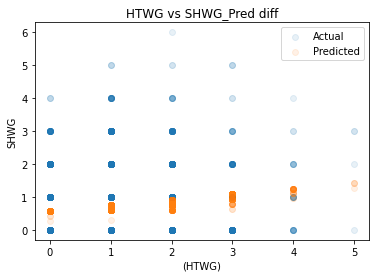

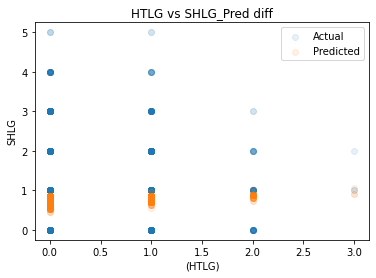

In [49]:

features = ['HTWG', 'HTLG']
target = 'ShWG'

data_copy = data.copy()




# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create a linear regression model
winning_model = LinearRegression()

losing_model = LinearRegression()

# Fit the model on the training data
winning_model.fit(train_data[['HTWG', 'HTLG']], train_data['SHWG'])

losing_model.fit(train_data[['HTWG', 'HTLG']], train_data['SHLG'])


test_data['SHWG_Pred'] = winning_model.predict(test_data[features])
test_data['SHLG_Pred'] = losing_model.predict(test_data[features])





# Compare actual second-half scoring difference with predicted second-half scoring difference
test_data['SHWGPredictionError'] = test_data['SHWG'] - test_data['SHWG_Pred']
test_data['SHLGPredictionError'] = test_data['SHLG'] - test_data['SHLG_Pred']

winning_scoring = test_data.groupby('HTWG')['SHWGPredictionError'].mean()
losing_scoring = test_data.groupby('HTLG')['SHLGPredictionError'].mean()



winning_coeffs = winning_model.coef_
losing_coeffs = losing_model.coef_





print(f'Winning Coefficients:{winning_coeffs}')
print(f'Losing Coefficients: {losing_coeffs}')
print(f'features{features}')



print("---------------------------")
print("---------------------------")

# Plotting the results
plt.scatter(test_data['HTWG'], test_data['SHWG'], label='Actual', alpha = 0.1)
plt.scatter(test_data['HTWG'], test_data['SHWG_Pred'], label='Predicted', alpha = 0.1)

plt.xlabel('(HTWG)')
plt.ylabel('SHWG')
plt.legend()
plt.title('HTWG vs SHWG_Pred diff')
plt.show()
      
plt.scatter(test_data['HTLG'], test_data['SHLG'], label='Actual', alpha = 0.1)
plt.scatter(test_data['HTLG'], test_data['SHLG_Pred'], label='Predicted', alpha = 0.1)

plt.xlabel('(HTLG)')
plt.ylabel('SHLG')
plt.legend()
plt.title('HTLG vs SHLG_Pred diff')
plt.show()




The coefficients can be interpreted as such: the winning team at half time tends to have more variability in the number of goals they score in the second half than the losing team at half time-demonstrated by the winning_model having higher coefficients for both predictors

The winning team at halftime may be more likely to have a high scoring second half than the losing team (makes sense)

In general, the fact that the losing_model has coefficients that are similiar (though lower) than the winning_model makes it seem that the second half performance of both teams is not expected to be too different from each other, and because we have seen

The percentage of comebacks to be non-negligibile, it details that comebacks do happen with a fairly high frequency, though they are of course not to be expected. Even then, there are a recognizable amount of situations where situations that are deemed extremely unlikely had occured



## Question 2 : Identifying if there is "momentum" in the total amount of goals scored in the game; does a high scoring first-half imply a high(er) scoring second half? Or is the inverse true? Or neither?







In [50]:
data['HTG'] = data['HTHG'] + data['HTAG']
data['FTG'] = data['FTHG'] + data['FTAG']
data['SHG'] = data['FTG'] - data['HTG']
def favorite_htg(row):
    if row['Favorite']==row['HomeTeam']:
        return row["HTHG"]
    else:
        return row['HTAG']
    #This method returns the number of goals that the favorite team has at halftime
def unfavorite_htg(row):
    if row['Favorite']==row['HomeTeam']:
        return row["HTAG"]
    else:
        return row['HTHG']
    
        #This method returns the number of goals that the unfavorite team has at halftime

data['Favorite_htg'] = data.apply(favorite_htg, axis=1)
data['Unfavorite_htg'] = data.apply(unfavorite_htg, axis=1)



---------------------------
Linear Coefficients:[ 0.02721632  0.03940115 -0.05814303  0.28947978 -0.06964792 -0.01293387
  0.00732626]
features['Favorite_htg', 'Unfavorite_htg', 'PSH', 'PSD', 'PSA', 'ov25', 'un25']
---------------------------


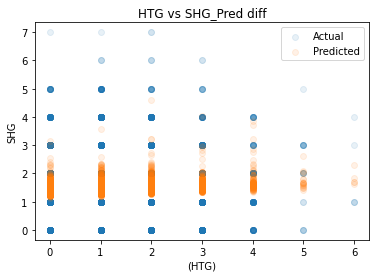

In [51]:

features = ['Favorite_htg', 'Unfavorite_htg', 'PSH','PSD', 'PSA', 'ov25', 'un25']
target = 'SHG'

data_copy = data.copy()

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()


# Fit the model on the training data
model.fit(train_data[['Favorite_htg', 'Unfavorite_htg', 'PSH','PSD', 'PSA', 'ov25', 'un25']], train_data['SHG'])


test_data['SHG_Pred'] = model.predict(test_data[features])



mse = mean_squared_error(test_data[target], test_data['SHG_Pred'])



# Compare actual second-half scoring with predicted second-half scoring
test_data['PredictionError'] = test_data[target] - test_data['SHG_Pred']


# Analyze the results to see if there is a trend in overall scoring
Scoring = test_data.groupby('HTG')['PredictionError'].mean()


coef = model.score(test_data[features], test_data[target])
coeffs = model.coef_



print("---------------------------")



print(f'Linear Coefficients:{coeffs}')
print(f'features{features}')



print("---------------------------")

# Plotting the results
plt.scatter(test_data['HTG'], test_data['SHG'], label='Actual', alpha = 0.1)
plt.scatter(test_data['HTG'], test_data['SHG_Pred'], label='Predicted', alpha = 0.1)

plt.xlabel('(HTG)')
plt.ylabel('SHG')
plt.legend()
plt.title('HTG vs SHG_Pred diff')
plt.show()

We can see the coeficients, and understand that there seems to be a positive correlation on the number of goals

In the first half. In general, when the unfavorite team has more goals in the first half it has a more significant effect on the goals in the second half (this makes sense, as most of the time when the unfavored team has goals, the favored team will also have goals. The converse is not necessarily true)

Also, there are more goals expected when there the odds are skewed more towards one team ,which makes sense. This is also shown by low chances of a draw (Higher PSD) causing an expectation of more goals

Finally, it is intuitive that low ov25 correlates with more goals, and lower un25 correlates with less goals

In general, more goals in the first half seems to predict more goals in the second half.

This indicates a trend of momentum as it pertains to more goals in the first half transititioning to a high scoring second half

We will do more observation of averages. Due to the data (of goals) being all in integers, it makes it difficult to plot even a polynomial regression, to observe a downward trend that is present when the number of goals in the first half is very large. We can see this through other visualization though.

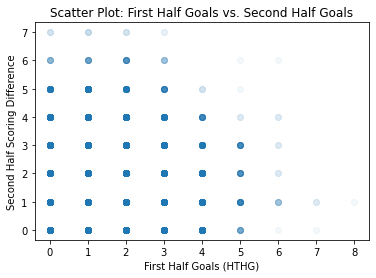

In [52]:

import matplotlib.pyplot as plt

# Scatter plot
plt.scatter(data['HTG'], data['SHG'], alpha = 0.05 
           )

# Adding labels and title
plt.xlabel('First Half Goals (HTHG)')
plt.ylabel('Second Half Scoring Difference')
plt.title('Scatter Plot: First Half Goals vs. Second Half Goals')

# Show the plot
plt.show()


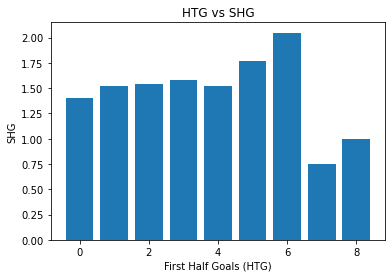

In [53]:


# Group by 'HTHG' and calculate the mean of 'SecondHalf_Scoring_Difference'
grouped_data = data.groupby('HTG')['SHG'].mean().reset_index()

# Bar plot
plt.bar(grouped_data['HTG'], grouped_data['SHG'])

# Adding labels and title
plt.xlabel('First Half Goals (HTG)')
plt.ylabel('SHG')
plt.title('HTG vs SHG')

# Show the plot
plt.show()


Finally, from these last two plots, we could see that the predicted trend of the regression hold, until we observe an extremely large number of goals in the first half (7-8), which has observed results of a lower scoring second half. 

Overall, the idea of a momentum tendency is very intuitive. You can expect that if the first half is low-scoring, the teams could be very close in skill,  or it could be that both defenses having a strong day, or attackers having a bad day. In this case, you would expect the same to hold in the second half, and for it to remain a close match as it was in the first half, with few goals.

Also, if many goals are scored in the first half, it makes sense that it could be the case that the teams' defenses are having an off day, or teams are not as evenly matched, causing more chances to be created than there would be in a slower paced game. So, if there are a higher number of goals scored in the first half, it would make sense that there are also a higher number of goals in the second half, as the teams would still have the same parameters that caused the higher number of goals to occur in the first place.

Finally, to explain why an extremely high number of goals may result in less goals in the second half, which is something that breaks the observed trend and rationale, it is understandable that in this case, it is likely one team has a large lead over another. In this case, the leading team would often sub off starters and play a slower pace, focusing on not conceding and maintaining their lead, rather than growing it. So, with added focus on defense for the dominant team, the scoring would be slow in the second half. In another case where both teams have scored many goals, it is sensible that the players may be tired, and also that managers may make substitutions to try and clean things up. As a result, in these extreme scoring cases, it makes sense that there is a lack of scoring in the second half. However, for the majority of games, the momentum trend still holds. 
